# Formal verification of deep neural networks: a tutorial

The aim of this tutorial is to give a glimpse on the practical side of Formal Verification for Deep Neural Networks.
This tutorial is divided in four part:
1. Verification by hand
2. Small problem verification
3. Real use case application
4. Image classification

The tutorial material was written by Augustin Lemesle (CEA List) with material provided by Serge Durand (CEA) based on a previous tutorial created by Julien Girard-Satabin (CEA LIST/INRIA), Zakaria Chihani (CEA LIST) and Guillaume Charpiat (INRIA).

## Part 1: Verification by hand

This first part aims to give a rough overview of the challenges posed by the verification of a neural network. In the first part of the lesson you should have seen a technique called Abstract Interpretation which can leverages intervals to estimate the output of a network. You should have seen an example by hand of this method. In this part, we will developp a small class that will calculate the output automatically with intervals.

### Step 1: Encode the network

![image](imgs/network.png)

With the above network create a function `network(x1, x2)` which reproduces its comportement. It must pass the tests created in `test_network`. For the relu layer, its function is already implemented here.

In [9]:
def relu(x):
    return max(0, x)

def network(x1, x2):
    # apply all the operations
    x3 = 2*x1 + x2 + 1
    x4 = -x1 + x2
    x3p = relu(x3)
    x4p = relu(x4)
    x5 = 2*x4p - 0.5*x3p - 1
    x6 = x4p - x3p + 2
    y = x5 - x6
    return y

In [10]:
def test_network():
    assert network(0, 0) == -2.5
    assert network(0, -1) == -3
    assert network(0, 1) == -1
    assert network(-1, 1) == -1
    assert network(-1, 0) == -2
    assert network(-1, -1) == -3
    assert network(1, 0) == -1.5
    assert network(1, -1) == -2
    assert network(1, 1) == -1
    
test_network()

### Step 2: Create an Interval

Following the rules of interval arithmetic write a class representing an Interval by overriding Python operators. A skeleton is avalaible below.

Intervals rules:
- $[l, u] + \lambda = [l + \lambda, u + \lambda]$
- $[l, u] + [l', u'] = [l + l', u + u']$
- $-[l, u] = [-u, -l]$
-$[l, u] - [l', u'] = [l - u', u - l']$
- $[l, u] * \lambda =$
  - si $\lambda >= 0$ -> $[\lambda * l, \lambda * u]$
  - si $\lambda < 0$ -> $[\lambda * u, \lambda * l]$
  
We will also need to update the relu for it to work on intervals.

Some tests are available for you to check if the class implementation is correct.

In [64]:
class Interval:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper
    
    def __add__(self, other):
        if isinstance(other, Interval):
            return Interval(self.lower + other.lower, self.upper + other.upper)
        else:
            return Interval(self.lower + other, self.upper + other)
            
    def __sub__(self, other):
        if isinstance(other, Interval):
            return self.__add__(other.__neg__())
        else:
            return Interval(self.lower - other, self.upper - other)
        
    
    def __neg__(self):
        return Interval(-self.upper,-self.lower)
    
    def __mul__(self, other):
        if isinstance(other, Interval):
            return Interval(self.lower, self.upper)
        else:
            if(other < 0):
                return Interval(self.upper * other,self.lower * other)
            else:
                return Interval(self.lower * other, self.upper * other)
            
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __str__(self):
        return f"[{self.lower}, {self.upper}]"

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lower == other.lower and self.upper == other.upper

In [65]:
def relu(x):
    if isinstance(x, Interval):
        lower = max(0, x.lower)
        upper = max(0, x.upper)
        return Interval(lower, upper)
    else:
        return max(0, x)

In [66]:
def test_interval():
    assert Interval(0, 1) == Interval(0, 1)
    assert -Interval(0, 1) == Interval(-1, 0)
    assert Interval(0, 1) + Interval(1, 2) == Interval(1, 3)
    assert Interval(0, 1) - Interval(1, 2) == Interval(-2, 0)
    assert Interval(-1, 2) * 3 == Interval(-3, 6)
    assert Interval(-1, 2) * -3 == Interval(-6, 3)
    assert relu(Interval(-2, 3)) == Interval(0, 3)
    
test_interval()

### Step 3: Run the network with intervals

At this point you should be able to run the network using the interval class and see the output reached.

In [67]:
print(network(Interval(-1, 1), Interval(-1, 1)))

[-7.0, 5.0]


### Bonus step: To go further

- Reproduce the first neural network from the slides to confirm the results
- Implement a class for an AffineForm to compute more precise outputs

*****

## Part 2: Small problem verification

We provided a toy problem representative of current challenges in neural network verification. We also trained a deep neural network to answer this problem.

The goal of this section for the participants is to formally verify that the neural network is _safe_, using the bundled tools.

## Problem definition

This toy problem is inspired by the Airborne Collision Avoidance System for Unmanned vehicles (ACAS-Xu) specification and threat model. 

![problem formulation](imgs/problem_small.png)

Let A be a Guardian, and B a Threat.
The goal for the Guardian is to send an ALARM when the Threat arrives too close.

The Guardian has access to the following data:
* The distance from B to A, $d = ||\vec{d}||$
* the speed of B, $v =||\vec{v} ||$
* the angle $\theta$ between $\vec{d}$ and $\vec{v}$

All values are normalized in $\left[0,1\right]$, the angle is not oriented.

We want to define three main ”zones”:
1. a **”safe”** zone: when B is in this zone, it is not considered a threat for any $||\vec{d}|| > \delta_2$, no ALARM is issued.
2. a **”suspicious”** zone: when B is in this zone, if $||\vec{v}|| > \alpha$ and $\theta < \beta$
   then a ALARM should be issued. Else, no ALARM is issued.
3. a **”danger”** zone: when B is in this zone, a ALARM is issued no matter what. When $||\vec{d}|| < \delta_1$, B is in the danger zone.

  
### Solving this problem with a neural network

A neural network was pre-trained to solve this task (all files used to this end are available). 
It has 5 fully connected layers, the first layer takes 3 inputs and the last layer has 1 output. There are four hidden layers: first and second hidden layers are of size 10, the third is size 5 and the fourth is size 2. We used ReLUs as activation functions. 

The network was trained to output a positive value if there is an alarm, and a negative value if there is no alarm. For a detailed summary of hyperparameters, you may check the defaults in `train.py`. It achieved 99.9% accuracy on the test set, with a total training set of 100000 samples.

The specification used to train the network is based on :
- $\alpha = 0.5$
- $\beta = 0.25$
- $\delta_1 = 0.3$
- $\delta_2 = 0.7$

We will aim to prouve that it respects these values.


## Create the safety property

The trained network is in the repository, under the filename `network.onnx`. Your goal is to learn how to write a safety property and launch different tools on the network.


### Step 1: Visualization 

You can first visualize the network answer on the output space by sampling inputs,
using the function below (**careful, it may take time if you input a big number of samples!**).

`sample2d` is faster but sample only on a 2d slice, `sample3d` gives a full representation of the output space.

Blue color denotes no alert, red color denotes an alert.


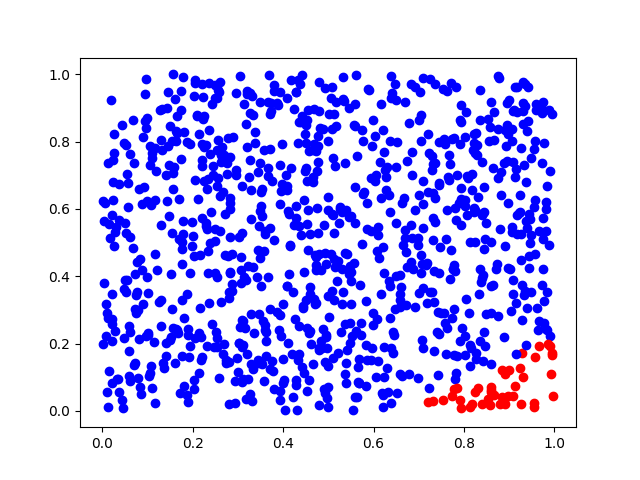

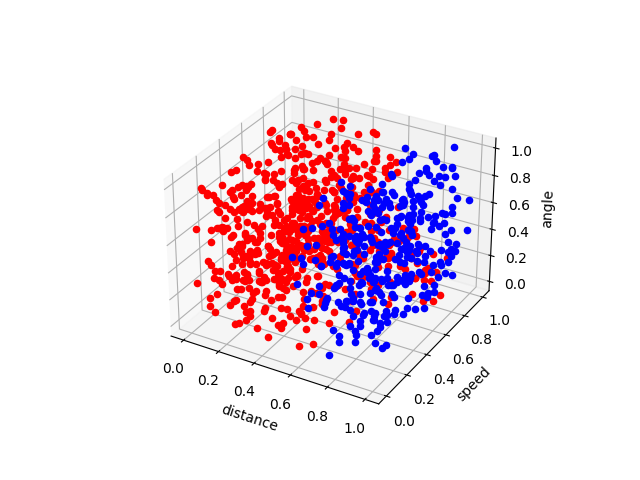

In [68]:
from visualize_outputs import sample2d, sample3d, plot2d, plot3d
from onnx2pytorch import convert

%matplotlib widget

n_sample = 1000  # number of points to sample
frozen_dim = 0    # which dimension will have a constant value for the 2d plot, (0: distance, 1: speed, 2: angle)
frozen_val = 0.9    # constant value to give to the frozen dimension
model = convert("network.onnx")
dim_1, dim_2, colours = sample2d(model, n_sample, frozen_dim, frozen_val)
plot2d(dim_1, dim_2, colours)
dim_1, dim_2, dim_3, colours = sample3d(model, n_sample)
plot3d(dim_1, dim_2, dim_3, colours)

On this plot we can already start to see some tendencies of alarms. As always the difficult part will be at the decision boundary.

### Step 2: Write some safety property

Let us say we would like to check the following property:

"No input above a distance .95 output an alarm". 

If our neural network correctly follows our specification, it should respect this property (since the distance is above 0.7, no alarm should be issued).

The basics for formulating properties to our various tools is the following:

1. Write constraints on inputs as defined in the specification
1. State the contraint on outputs you want to check
1. For tools using SMT, write down the negation of this constraint
   (remember in the course section, VALID(F) is equivalent to ¬SAT(¬F)). 

For this tutorial, we wrote a simple API to make easier the writing of properties to check. This API is detailed inside `formula_lang.py` in the repository.
This API allows to define linear constraints on symbolic variables and real values.
* To define a new variable, use the constructor `Var(x)`, where `x` must be a string
* To define a new real number, use `Real(r)` where `r` is a python number
* A constraint is a linear inequality between two variables or reals. To create a new constraint, use
  `constr = Constr(var1, bop, var2)` where `bop` is either `'>='` or `<`.
* You can create multiple constraints
* Finally, once you are satisfied, you can add your constraints to a formula. A formula is a conjunction of constraints
* `f = Formula()` creates an empty constraint, and `f.add(constr)` add the constraint `constr` to the formula.
  `f.add(c1)` followed by `f.add(c2)` is equivalent to adding a conjunction of `c1` and `c2`


Here is how to use it:
#### Variables creations
1. Create a new variable with `var = Var(str)`; `str` should be    
  either `'x0'`, `'x1'`, `'x2'` or `'y0'`, respectively the first, 
  second and third input and only output. For convenience, they 
  are already defined when executing the cell below as
  `distance`, `speed`, `angle` and `output`
  
2. Create a new real value with `real = Real(r)` where `r`
  can be an integer or a float (all variables will be converted
  as real values). For instance, `real = Real(0.95)`
  
  
#### Creating constraints and adding them to a formula
1. Create a new constraint between a variable `var` and a
  real value `real` with `constr = Constr(var, bop, real)` where
  `bop` is either `'>='` or `'<'`. For instance, `constr = Constr(distance,'>=',real)`
2. Create a new empty formula with `f = Formula()`
3. Add a constraint `constr` to a formula `f` with `f.add(constr)`. 
    
#### Printing and saving to disk
1. Print a formula `f` with `print(f)`
2. Write down a formula `f` to SMTLIB2 format at destination `dest`
  with `f.write_smtlib(dest)`; similarly for Marabou format,
  use `f.write_marabou(dest)` or PyRAT format `f.write_pyrat(dest)`.
  For smtlib or marabou the negation of the output is done automatically.

A simple example is given below for the property "No input above a distance .95 output an alarm".

In [69]:
from formula_lang import *

distance = Var('x0')
speed = Var('x1')
angle = Var('x2')

output = Var('y0')

one = Real(1)
real = Real(0.95)
zero = Real(0)

constrs = []
constrs.append(Constr(distance, '>=', real))
constrs.append(Constr(distance, '<', one))
constrs.append(Constr(speed, '>=', real))
constrs.append(Constr(speed, '<', one))
constrs.append(Constr(angle, '>=', real))
constrs.append(Constr(angle, '<', one))
constrs.append(Constr(output, '<', zero))

formula = Formula()
for c in constrs:
    formula.add(c)
    
print(formula)
    
formula.write_smtlib()
formula.write_marabou()
formula.write_pyrat()

x0 >= 0.95; x0 < 1; x1 >= 0.95; x1 < 1; x2 >= 0.95; x2 < 1; y0 < 0; 
Wrote SMT formula in file formula.smt2
Wrote marabou formula in file formula.marabou
Wrote pyrat formula in file formula.txt


## Launch solvers and recover results

As mentioned, we will use three tools in this tutorial:

1. Z3, a theorem prover from Microsoft Research [https://github.com/Z3Prover/z3](https://github.com/Z3Prover/z3), used as a state-of-the-art SMT solver; however it does not have any particular heuristics to work on neural networks 
2. PyRAT, a tool internally developped at the lab, that leverages abstract interpretation to verify reachability properties on neural networks. The source is currently not available, if you want to access it just send us an email
3. Marabou, a solver tailored for neural network verification: it uses a specialized Simplex algorithm and merges relevant neurons. See [the paper](https://arxiv.org/abs/1910.14574) for more details

You will notice that PyRAT performs a "reachability analysis" (given the input range, what is the possible output range?). Marabou does not deal with disjunction of clauses ($a< x1 <b \vee c < x1 <d$), so you will need to formulate the two clauses in separate properties (one with $a< x1 <b$, one with $c < x1 <d$).

It is partly due to implementation constraints, and on such simple problem this should not be a limitation. But the set of expressible properties is different between abstract interpretation and SAT/SMT calculus.

Here is a recap about the tools we will be using:

| | Z3 | Marabou | PyRAT 	|
|----------------------------------	|--------------------------------	|--------------------------------------	|-------------------------	|
| input format                     	| SMTLIB  	| Specific  	| Specific      	|
| technology                       	| SMT                            	| SMT / overapproximation              	| abstract interpretation 	|
| specialized  for neural networks 	| no                             	| yes                                  	| yes                     	|

### Step 1: Z3 the classical SMT solver

As mentioned, Z3 is not made for neural networks specifically, we are simply transforming the network as a classical problem for the solver to handle. For this, we will thus need to transform the network to the SMT format first before launching the tool. This is done in `call_isaeih` using the open-source ISAEIH tool developed at CEA. The `launch_z3` function will then call the solver directly on the transformed network

In [70]:
import os
import time

def call_isaieh(fpath):
    """Convert an ONNX network at fpath to a SMT formula describing;
    the control flow. The output will be called fpath_QF_NRA.smt2"""
    !./bin/isaieh.exe -theory=QF_NRA $fpath

In [71]:
call_isaieh('network.onnx')

/bin/bash: ./bin/isaieh.exe: Permission non accordée


In [72]:
def launch_z3(control_flow, constraints, verbose=True):
    """Launch z3 on the SMT problem
    composed of the concatenation of a control flow and constraints, both written in SMTLIB2"""
    !cat $control_flow $constraints > z3_input
    
    t = time.perf_counter()
    output = !z3 z3_input
    output = "\n".join(output)
    if verbose:
        print(output)
        
    return "unsat" in output, time.perf_counter() - t    

To launch Z3, provide the filepath of the network's control flow in SMTLIB as well as the filepath of the
formula you generated. 

A **SAT** result will be followed by an instanciation of the input and outputs that satisfies the negation of your property, i.e. a counter-example. 

An **UNSAT** result signifies that it could not find such a counter example and that your property holds.

In [73]:
res, t_z3 = launch_z3('network_QF_NRA.smt2','formula.smt2')

cat: network_QF_NRA.smt2: Aucun fichier ou dossier de ce type
/bin/bash: z3 : commande introuvable


### Step 2: Marabou the simplex-based solver

As opposed to Z3, Marabou is tailor-made for neural network. It uses its own property format and can only read network under the NNet format. We already provide a copy of the ONNX network in NNET that was made using a converter `network.nnet`.

In [74]:
def launch_marabou(network, constraints, verbose=True):
    """Launch marabou on the verification problem:
    network is a .nnet description of the network (provided here
    for simplicity) and constraints is a property file you wrote"""
    t = time.perf_counter()
    output = !./bin/marabou.elf --timeout=100 $network $constraints
    output = "\n".join(output)
    if verbose:
        print(output)
    return "unsat" in output.lower(), time.perf_counter() - t    

Similarly for Marabou, provide the filepath of model and the property you generated in the Marabou format. The output of Marabou is more verbose dans Z3, the important part lies at the end: SAT or UNSAT. 

In [75]:
res, t_marabou = launch_marabou("network.nnet", 'formula.marabou')

/bin/bash: ./bin/marabou.elf: Permission non accordée


### Step 3: PyRAT with Abstract Interpration

PyRAT API provide directly a function to launch the analysis `launch_pyrat`. Remember that a _negative value_ means
no alarm issued, while a _positive value_ means that an alarm is issued. 

PyRAT can directly work on the ONNX network while its input format is similar to the Marabou with only the difference of having the property to prouve instead of its negation.
- **True** means the property holds,
- **False** means it does not.

PyRAT will also output the bounds reached at the end of the analysis.

In [76]:
from pyrat_api import launch_pyrat

res, t_pyrat = launch_pyrat("network.onnx", "formula.txt")

Output bounds:
 [-6.0188885]
[-5.915209]
Result = True, Time = 0.00 s


With PyRAT you can also use different abstract domains to get a more precise results, avalaible domains are "poly", "zono", "symbox". While they increase precision they also increase computation time. Nevertheless, unless we are in such simple setting the interval by themselves are often too imprecise to conclude.

An additional argument `split_timeout` can also help to increase the precision of the analysis. Try it for now and we will see it in more details in the next section.

In [77]:
res, t_pyrat = launch_pyrat("network.onnx", "formula.txt", domains=["zono"], split_timeout=10)

Result = True, Time = 0.01 s, Safe space = 100.00 %, number of analysis = 1


## Moving to bigger properties

You were able to launch solvers to verify this simple property. We can already notice that Z3 took significantly more time than the others to return a result: it comes from the suboptimal encoding of the problem as well as the lack of heuristics tailored to neural network verification. Using Z3 on more complex properties will likely hang your session; don't hesitate to terminate the cell's execution if it takes too much time.

Even so, with all three tools we managed to prove the simple property we created. But this property was not the one we initially mentioned. We should aim to answer the following questions:
- With the setting of $\alpha = 0.5$, $\beta = 0.25$, $\delta_1 = 0.3$, $\delta_2 = 0.7$ can we prove our three initial properties on this network ?
- If not for what values of $\alpha, \beta, \delta_1$ and $\delta_2$ do they hold ?

Initial properties of the zones:
1. a **”safe”** zone: when B is in this zone, it is not considered a threat for any $||\vec{d}|| > \delta_2$, no ALARM is issued.
2. a **”suspicious”** zone: when B is in this zone, if $||\vec{v}|| > \alpha$ and $\theta < \beta$
   then a ALARM should be issued. Else, no ALARM is issued.
3. a **”danger”** zone: when B is in this zone, a ALARM is issued no matter what. When $||\vec{d}|| < \delta_1$, B is in the danger zone.

**Write these properties and try proving them with the different tools**. 

In [154]:
from formula_lang import * 

distance = Var('x0')
speed = Var('x1')
angle = Var('x2')

output = Var('y0')

one = Real(1)
delta_1 = Real(0.2)
delta_2 = Real(0.78)
alpha = Real(1)
beta = Real(0.01)
zero = Real(0)

# Safe
constrs = []
constrs.append(Constr(distance, '>=', delta_2))
constrs.append(Constr(distance, '<', one))
constrs.append(Constr(speed, '<', zero))
constrs.append(Constr(speed, '>=', zero))
constrs.append(Constr(angle, '>=', zero))
constrs.append(Constr(angle, '<', one))
constrs.append(Constr(output, '<', zero))

formula_safe = Formula()
for c in constrs:
    formula_safe.add(c)
    
# Suspicious
constrs = []
constrs.append(Constr(distance, '>=', zero))
constrs.append(Constr(distance, '<', one))
constrs.append(Constr(speed, '>=', alpha))
constrs.append(Constr(speed, '<', one))
constrs.append(Constr(angle, '>=', zero))
constrs.append(Constr(angle, '<', beta))
constrs.append(Constr(output, '>=', zero))

formula_sus = Formula()
for c in constrs:
    formula_sus.add(c)
    
    
# Danger
constrs = []
constrs.append(Constr(distance, '>=', zero))
constrs.append(Constr(distance, '<', delta_1))
constrs.append(Constr(speed, '>=', zero))
constrs.append(Constr(speed, '<', one))
constrs.append(Constr(angle, '>=', zero))
constrs.append(Constr(angle, '<', one))
constrs.append(Constr(output, '>=', zero))

formula_danger = Formula()
for c in constrs:
    formula_danger.add(c)
    
print(formula)
    
formula_safe.write_pyrat("safe.txt")
formula_sus.write_pyrat("suspicious.txt")
formula_danger.write_pyrat("danger.txt")

x0 >= 0.7; x0 < 0.3; x1 >= 0.4; x1 < 1; x2 < 0.25; x2 >= 0; 
Wrote pyrat formula in file safe.txt
Wrote pyrat formula in file suspicious.txt
Wrote pyrat formula in file danger.txt


In [155]:
res, t_pyrat = launch_pyrat("network.onnx", "safe.txt", domains=["zono"], split_timeout=10)
res, t_pyrat = launch_pyrat("network.onnx", "suspicious.txt", domains=["zono"], split_timeout=10)
res, t_pyrat = launch_pyrat("network.onnx", "danger.txt", domains=["zono"], split_timeout=10)
#res, t_marabou = launch_marabou("network.nnet", 'formula.marabou')
#res, t_z3 = launch_z3('network_QF_NRA.smt2','formula.smt2')

Result = True, Time = 0.01 s, Safe space = 100.00 %, number of analysis = 1
Result = False, Time = 0.04 s, Safe space = 75.00 %, number of analysis = 7
Result = True, Time = 0.07 s, Safe space = 100.00 %, number of analysis = 11


*****

## Part 3: A real problem ACAS-Xu

Let's tackle a more complex network of the public benchmark of Airborne Collision Avoidance System for Unmanned vehicles (ACAS-Xu). For an introduction of the ACAS-Xu benchmark, see _An Introduction to ACAS Xuand the Challenges Ahead , Manfredi G., Jestin Y._

Formerly, programs such as ACAS were implemented as a lookup table. The neural network approach was partly introduced to reduce the memory requirements for hardware of the original 2GB tables down to 3MB. Neural network becoming more and more efficient, industrials considered using them as a possible replacement. Since we are dealing with critical systems, software safety is a major concern.

In _Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks_ , Katz et al. provided a neural network implementation of a ACAS-Xu system, as well as a tooling to formally verify several safety properties. It was then adopted as a common benchmark in the literature.

The problem is similar to our previous one, a neural network needs to give direction advisory to a drone when an intruder is detected at proximity. The advisory can be "Clear of Conflict" meaning there is no risk of collision, "Right", "Strong Right", "Left", "Strong Left" for evasion direction. The minimum score will correspond to the decision taken.

![acas](imgs/acas.png)

The network takes 5 inputs:
- ρ (m): Distance from ownship to intruder.
- θ (rad): Angle to intruder relative to ownship heading
direction.
- ψ (rad): Heading angle of intruder relative to ownship
heading direction.
- $v_{own}$ (m/s): Speed of ownship.
- $v_{int}$ (m/s) Speed of intruder.

We want to prove one property on this network: 

**Property 1.**
- Description: If the intruder is distant and is significantly slower than the
ownship, the score of a COC advisory will always be below a certain fixed
threshold.
- Input constraints: ρ ≥ 55947.691, $v_{own} ≥ 1145$, $v_{int} ≤ 60$.
- Desired output property: the score for COC is at most 1500.

The formulas for this property are already written. Normalised values will be given below.

In [156]:
from formula_lang import formula_p1
from pyrat_api import launch_pyrat

formula_p1().write_pyrat("formula_p1.txt")
formula_p1().write_marabou("formula_p1.marabou")

res, t_pyrat = launch_pyrat("acas.nnet", "formula_p1.txt", domains=["zono"])
#res, t_marabou = launch_marabou("acas.nnet", 'formula_p1.marabou') # does not finish

Wrote pyrat formula in file formula_p1.txt
Wrote marabou formula in file formula_p1.marabou
Output bounds:
 [-10710.81020574  -9110.01167952 -12047.17947303  -2730.80270361
 -13194.04888676]
[ 5272.51746506  5429.67755395  4817.41682782 10864.69018591
  5844.88081043]
Result = Unknown, Time = 0.01 s


In [158]:
# splitting the inputs
res, t_pyrat = launch_pyrat("acas.nnet", "formula_p1.txt", domains=["zono"], split_timeout=100)

Result = True, Time = 2.97 s, Safe space = 100.00 %, number of analysis = 281


We can see here that PyRAT performs 281 analysis on this property in total. Indeed after failing to prove the property at the begining it divides the input space and perform subsequent analysis until it proves the property. At the same time we see that Marabou takes too long to prove the property so we might want to accelerate this.

In this part, we will aim to facilitate the analysis similar to the `split_timeout` option of PyRAT. For this we will divide the input space into smaller parts before performing the analysis on smaller parts.

### Step 1: Divide a formula

We will first look at how to divide the input space for our problem. As we worked until now on Formulas it might not be evident to divide them as they are mostly in a textual form. We will thus come back to our Interval class, which we can easily divide, then transform an Interval into a constraint that we can add into a Formula.

**Write the following functions.** `create_formula_p1` is already written and should properly create a formula if `interval_to_constraint` is correctly implemented.

In [169]:
def divide_interval(x: Interval) -> (Interval, Interval):
    if isinstance(x, Interval):
        return Interval(x.lower, (x.upper+x.lower)/2), Interval((x.upper+x.lower)/2, x.upper)
    raise NotImplementedError

assert divide_interval(Interval(0, 1)) == (Interval(0, 0.5), Interval(0.5, 1))
assert divide_interval(Interval(-5, 1)) == (Interval(-5, -2), Interval(-2, 1))

In [171]:
from typing import List

def interval_to_constraint(x: Interval, name: str) -> (Constr, Constr):
    if isinstance(x, Interval):
        return Constr(Var(name), '>=', Real(x.lower)), Constr(Var(name), '<', Real(x.upper))
        

def create_formula_p1(inputs: List[Interval]) -> Formula:
    output = Var('y0')

    constrs = []
    for i in range(len(inputs)):
        constrs.extend(interval_to_constraint(inputs[i], f"x{i}")) # for each input interval we create and add the constraint
        
    constrs.append(Constr(output, '<', Real(3.9911256459))) # constraint on the output

    formula = Formula()
    for c in constrs:
        formula.add(c)

    return formula

initial = [Interval(0.6, 0.6798577687), Interval(-0.5, 0.5), Interval(-0.5, 0.5), Interval(0.45, 0.5), Interval(-0.5, 0.45)]
print(create_formula_p1(initial))

x0 >= 0.6; x0 < 0.6798577687; x1 >= -0.5; x1 < 0.5; x2 >= -0.5; x2 < 0.5; x3 >= 0.45; x3 < 0.5; x4 >= -0.5; x4 < 0.45; y0 < 3.9911256459; 


### Step 2: Iteration algorithm

Now we can generate formula from intervals and divide the intervals, we can start working on an algorithm to divide the input space for the analysis. The general idea of the algorithm would be:

1. Initial: 1 Interval per input as defined by the property
2. Create a formula from the intervals
3. Run an analysis with eith PyRAT or Marabou (Marabou has a timeout of 100 it can be changed in `launch_marabou`)
4. If property is verified stop. 
   Otherwise, divide an interval in 2 and come back to step 2 for both subspaces created
5. If all subspaces are proven True/unsat we can conclude that the initial space is as well.

`launch_pyrat` and `launch_marabou` both return a tuple of `boolean, float` the boolean indicates if the property holds when it equals `True`. The float is the time taken for the analysis. Here do not use `split_timeout = 0` for PyRAT not to do any splitting on its own.

In [182]:
def analyse(inputs: List[Interval]):
    formula = create_formula_p1(inputs)
    formula.write_pyrat("formula.txt")
    res, t_pyrat = launch_pyrat("acas.nnet", "formula.txt", domains=["zono"])
    
    if(res == True):
         return True   
    else:
        i1 = []
        i2 = []
        for i in range(len(inputs)):
            i_div = divide_interval(inputs[i])
            i1.append(i_div[0])
            i2.append(i_div[1])
            
        analyse(i1)
        analyse(i2)
                              
initial = [Interval(0.6, 0.6798577687), Interval(-0.5, 0.5), Interval(-0.5, 0.5), Interval(0.45, 0.5), Interval(-0.5, 0.45)]
analyse(initial)

Wrote pyrat formula in file formula.txt
Output bounds:
 [-13703.76840556 -11650.49647462 -15399.48471075  -3491.64369193
 -16873.93784018]
[ 6741.31879213  6948.28653093  6161.77284022 13889.18982366
  7474.49709356]
Result = Unknown, Time = 0.01 s
Wrote pyrat formula in file formula.txt
Output bounds:
 [-3550.55339166 -3023.83749887 -4002.8480418   -902.79341163
 -4383.57122813]
[1745.18966127 1794.98362025 1593.07387949 3605.36711416 1933.38484528]
Result = Unknown, Time = 0.01 s
Wrote pyrat formula in file formula.txt
Output bounds:
 [-55.06820859 -46.94232084 -65.63917304 -19.87184717 -73.61251578]
[37.9098227  37.86804778 35.40315467 70.01284302 43.81451971]
Result = Unknown, Time = 0.01 s
Wrote pyrat formula in file formula.txt
Output bounds:
 [-0.02121775 -0.01879782 -0.01952425 -0.01893638 -0.0185982 ]
[-0.01423817 -0.01179154 -0.00823094 -0.01761423 -0.00731985]
Result = True, Time = 0.01 s
Wrote pyrat formula in file formula.txt
Output bounds:
 [-0.0207541  -0.01877377 -0.019

You can print some statistic like the number of analysis you do or the time taken. **Can you do less analysis than PyRAT?**

### Heuristics to go further

How could we reach the same number or lower of analysis from PyRAT:
- Can we select the interval to split more carefully?
- Can we ignore some of the preliminary analysis because we know they won't succeed?

*****

## Part 4: Choosing a network for image classification

For this section we will focus on an open source image dataset for classification purpose. The images we will use are a subset of the Fashion Mnist dataset ([available here](https://www.kaggle.com/datasets/zalando-research/fashionmnist)). This dataset was developed to replace the MNIST dataset which was overused and presents the same caracteristics:
- 28x28 grayscales images
- 10 output classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

![fmnist](imgs/fashion_mnist.png)

We will use a subset of 50 images for the purpose of this TP.


The goal for this part is to decide which model would be best suited for our needs. Let's suppose we are in a critical system where picking the right class for the cloth might lead to any potential damage (ecological, financial, loss of clients, ..). 

We propose 5 models trained with different methods:
1. **Baseline model**, normal training
2. **Adversarial model**, adversarial training
3. **Pruned model, normal** training + pruning
4. **Certified model**, certified training
5. **Pruned certified model**, certified training + pruning

We must decide on a model to use. The accuracy of the models is already calculated on the whole test set (more than 50 images). This is already a first criteria of choice as some training lead to less accuracy.

|Model | Accuracy|
|--- | ---|
|Baseline | 90.50%|
|Adversarial | 79%|
|Pruned | 89%|
|Certified | 72.30%|
|Pruned Certified | 73.20%|


### Step 1: Local robustness 

We will look at the local robustness of the five models around the 50 images from our subdataset. All models and images are  available in the `fmnist` folder. We already created two utility functions to read images and to launch PyRAT on an image and a network. `read_images` return a list of `(image_i, label_i)` while `local_robustness` returns the robustness of a network around an image for a given perturbation.

An example is given below with a bag image and a perturbation of 1/255 (1 pixel modified).

Image shape: (28, 28), label: 7
Robust: True, Time: 0.39942956200047774


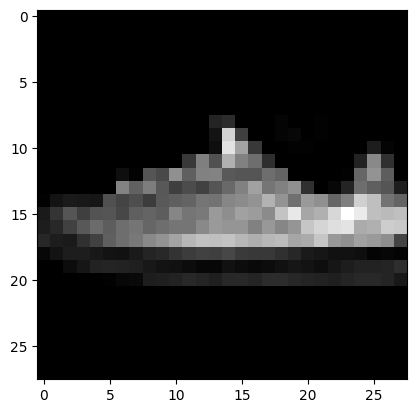

In [84]:
from pyrat_api import read_images, local_robustness
import matplotlib.pyplot as plt
%matplotlib inline

images = read_images()
image_0, label_0 = images[0]
print(f"Image shape: {image_0.shape}, label: {label_0}")
plt.imshow(image_0, cmap='gray')

res, elapsed = local_robustness(model_path="fmnist/baseline.onnx", image=image_0, label=label_0, pert=1/255, domains=["zono"])
print(f"Robust: {res}, Time: {elapsed}")

Now its your turn create a function that analyse all the given images for a given network and a given perturbation and returns a robustness score including safe images, unknown images and unsafe images as well as a mean time for the analysis.

In [85]:
def robustness(images, model_path, pert):
    raise NotImplementedError
    
robustness(images, "fmnist/baseline.onnx", 1/255) # should return [1, 48, 1]

NotImplementedError: 

With these results you can now try and plot the results to show the evolution in function of the level of intensity for the perturbation. We aim to see if a model is more robust than another to what could be adversarial perturbation. You can use matplotlib to plot these results. 

In [86]:
def plot_robustness():
    raise NotImplementedError

### Step 2: Metamorphic testing

We checked with the engineer in charge of taking pictures of the clothes on the condition in which he takes pictures. After a careful investigation we realised that the following issues might be happening in our picture:
- Luminosity of the setting varies from -30 to +30
- Angle of the clothes might vary from -15° to + 15°
- Picture can be blurry 

In that sense, to test the robustness of our model we will proceed to see if it is sensitive to these perturbations. Following the examples [here](https://opencv-tutorial.readthedocs.io/en/latest/trans/transform.html) use opencv library to implement transformation on the images. You can visualise the image with matplotlib.

In [87]:
def luminosity(image, intensity):
    raise NotImplementedError
    
def rotation(image, angle):
    raise NotImplementedError

def blur(image, intensity):
    raise NotImplementedError
    
plt.imshow(blur(image_0, 15))

NotImplementedError: 

To apply these transformation and compute the stability of a network towards we will use a tool developed at CEA called AIMOS which does exactly that.

After installing the aimos module (which is provided locally), the function below will call aimos on your transformation and a specified range before plotting the result.

In [88]:
!pip install ./bin/aimos_compile
from aimos import core

Processing ./bin/aimos_compile
  Created wheel for AIMOS: filename=AIMOS-1.0-py3-none-any.whl size=27865 sha256=b6149cb0febece22984ce1e9319ee6cb64109d5fac6dca16f576ffb60d8673fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-mr8hxog1/wheels/70/50/9d/c65b449093c72794e4464fe38d49de849130fb6a47de22aede
Successfully built AIMOS
You should consider upgrading via the '/home/NEMO18/.virtualenvs/tuto_seti/bin/python -m pip install --upgrade pip' command.


In [89]:
import numpy as np
import cv2

%matplotlib inline


def load_image(path):
    return np.load(str(path)).astype(np.float32).reshape((1, 28, 28))

def call_aimos(transformation, value_range):
    def identity(y):
        return y
    
    return core.main(
        "fmnist/images/",
        "fmnist/",
        (transformation, identity),
        custom_load=load_image,
        fn_range=value_range,
        single_plot=True,
        verbose=False,
        )

res = call_aimos(luminosity, range(0, 10))

NotImplementedError: 

At this point, you can run the above function on the different transformations that we want to test to see the different responses from the models. 

**What do you notice?**

### Step 3: Choose a model

**With all of these results, what model would you choose, why?**
